# 1. Libraries 

In [1]:
import os
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import optuna
import shap
import re
import statsmodels.api as sm
import warnings

from IPython.display import display, Markdown
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from pathlib import Path
from typing import List
from datetime import datetime
from xgboost import XGBRegressor
from functools import reduce

# 2. Data Cleaning and Processing

In [2]:
def load_all_dfs(root: Path) -> dict[str, pd.DataFrame]:
    """
    Recursively load every CSV, Excel and Parquet file under `root` into a dict.
    Keys are the relative path (from `root`), with separators and spaces replaced by underscores.
    """
    dfs: dict[str, pd.DataFrame] = {}
    for ext in ("*.csv", "*.xlsx", "*.xls", "*.parquet"):
        for fp in root.rglob(ext):
            key = (
                fp.relative_to(root)
                  .with_suffix("")         
                  .as_posix()              
                  .replace("/", "_")       
                  .replace(" ", "_")       
            )
            suffix = fp.suffix.lower()

            try:
                if suffix == ".csv":
                    dfs[key] = pd.read_csv(fp)
                elif suffix == ".parquet":
                    dfs[key] = pd.read_parquet(fp)
                elif suffix in (".xlsx", ".xls"):
                    # pick engine by extension
                    engine = "openpyxl" if suffix == ".xlsx" else "xlrd"
                    dfs[key] = pd.read_excel(fp, engine=engine)
            except Exception as e:
                print(f"⚠️  Skipping {fp!r} (key={key!r}): {e}")
    return dfs

In [3]:
# start from wherever this notebook’s cwd is
p = Path.cwd()

# walk up until we find a data/ and xgboost/ sibling
while p != p.parent:
    if (p / "data").exists() and (p / "xgboost").exists():
        break
    p = p.parent

print("Detected project root:", p)
print("  data/ exists?", (p / "data").exists())
print("  xgboost/ exists?", (p / "xgboost").exists())

# now point at those
data_root = p / "data"
iod_root  = p / "xgboost" / "IoD"
census_root = data_root / "census2021"
external_root = data_root / "externals"

print("Data root resolved to:", data_root)
print("IoD root resolved to: ", iod_root)
print("Census root resolved to:", census_root)
print("External root resolved to:", external_root)

Detected project root: /Users/youjungum/dc2
  data/ exists? True
  xgboost/ exists? True
Data root resolved to: /Users/youjungum/dc2/data
IoD root resolved to:  /Users/youjungum/dc2/xgboost/IoD
Census root resolved to: /Users/youjungum/dc2/data/census2021
External root resolved to: /Users/youjungum/dc2/data/externals


In [4]:
data_dfs = load_all_dfs(data_root)
iod_dfs = load_all_dfs(iod_root)
census_dfs = load_all_dfs(census_root)
external_dfs = load_all_dfs(external_root)

# sanity checks
# inspect a few keys to see the naming
print("Some data keys:", list(data_dfs.keys())[:5])
print("Some census keys:", list(census_dfs.keys())[:5])
print("Some external keys:", list(external_dfs.keys())[:5])

# now access the burglary CSV
print("burglary shape:", data_dfs["burglary_burglary-cleaned"].shape)

⚠️  Skipping PosixPath('/Users/youjungum/dc2/data/census2021/~$Household composition.xlsx') (key='census2021_~$Household_composition'): File is not a zip file
⚠️  Skipping PosixPath('/Users/youjungum/dc2/data/census2021/~$Age on arrival in UK.xlsx') (key='census2021_~$Age_on_arrival_in_UK'): File is not a zip file
⚠️  Skipping PosixPath('/Users/youjungum/dc2/data/census2021/~$Household composition.xlsx') (key='~$Household_composition'): File is not a zip file
⚠️  Skipping PosixPath('/Users/youjungum/dc2/data/census2021/~$Age on arrival in UK.xlsx') (key='~$Age_on_arrival_in_UK'): File is not a zip file
Some data keys: ['burglary_burglary-cleaned', 'externals_housing-density-ward', 'census2021_Households_by_deprivation_dimensions_(ONS_cyfrifiad)_TS011-2021-6', 'externals_land-area-population-density-london', 'census2021_Household_composition']
Some census keys: ['Households_by_deprivation_dimensions_(ONS_cyfrifiad)_TS011-2021-6', 'Household_composition', 'Economic_Activity', 'Country_of

In [5]:
print("→ Data frames:", len(data_dfs))
print("→ Census frames:", len(census_dfs))
print("→ External frames:", len(external_dfs))
print("→ IoD frames:", len(iod_dfs))
print()
print("Sample IoD keys:", list(iod_dfs.keys()))

→ Data frames: 9
→ Census frames: 5
→ External frames: 3
→ IoD frames: 14

Sample IoD keys: ['File_7_-_All_IoD2019_Scores__Ranks__Deciles_and_Population_Denominators_3', 'File_11_-_IoD2019_Local_Authority_District_Summaries__upper-tier__', 'File_5_-_IoD2019_Scores', 'File_2_-_IoD2019_Domains_of_Deprivation', 'File_4_-_IoD2019_Sub-domains_of_Deprivation', 'File_10_-_IoD2019_Local_Authority_District_Summaries__lower-tier__', 'File_12_-_IoD2019_Local_Enterprise_Partnership__LEP__Summaries', 'File_8_-_IoD2019_Underlying_Indicators', 'File_13_-_IoD2019_Clinical_Commissioning_Group__CCG__Summaries', 'File_1_-_IMD2019_Index_of_Multiple_Deprivation', 'File_3_-_IoD2019_Supplementary_Indices_-_IDACI_and_IDAOPI', 'File_9_-_IoD2019_Transformed_Scores', 'File_6_-_IoD2019_Population_Denominators', 'poverty_2013_update']


## 2.1 Exploring Predictor Variables

In [6]:
# ── 0) pandas display options ──
pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", None)
pd.set_option("display.width", None)

# ── A) auto-detect project root (must contain both data/ and xgboost/) ──
p = Path.cwd()
while p != p.parent:
    if (p / "data").exists() and (p / "xgboost").exists():
        break
    p = p.parent
print("Project root detected as:", p)

# ── B) define our folder roots from there ──
data_root = p / "data"
census_root = data_root / "census2021"
external_root = data_root / "externals"
iod_root = p / "xgboost" / "IoD"

print("data_root: ", data_root.exists(), data_root)
print("census_root: ", census_root.exists(), census_root)
print("external_root: ", external_root.exists(), external_root)
print("iod_root: ", iod_root.exists(), iod_root)

# ── 1) load burglary CSV ──
fp = data_root / "burglary" / "burglary-cleaned.csv"
print("\nLooking for:", fp)
print("Exists?  ", fp.exists())

df_burglary = pd.read_csv(fp)
print("\nColumns in burglary-cleaned.csv:")
for col in df_burglary.columns:
    print("•", col)

# ── 2) set up your file→sheets map ──
FILE_SHEETS = {
    # census2021
    census_root / "Age on arrival in UK.xlsx": ["2021"],
    census_root / "Country of birth.xlsx": ["2021"],
    census_root / "Economic Activity.xlsx": ["2021"],
    census_root / "Household composition.xlsx": ["2021"],
    census_root / "Households by deprivation dimensions (ONS cyfrifiad) TS011-2021-6.csv": [],

    # externals
    external_root / "hmlrppd-cleaned.parquet": [],
    external_root / "housing-density-ward.csv": [],
    external_root / "land-area-population-density-london.xlsx": ["Ward","Ward staging"],

    # IoD Excel files
    iod_root / "File_1_-_IMD2019_Index_of_Multiple_Deprivation.xlsx": ["IMD2019"],
    iod_root / "File_2_-_IoD2019_Domains_of_Deprivation.xlsx": ["IoD2019 Domains"],
    iod_root / "File_3_-_IoD2019_Supplementary_Indices_-_IDACI_and_IDAOPI.xlsx": ["IoD2019 IDACI & IDAOPI"],
    iod_root / "File_4_-_IoD2019_Sub-domains_of_Deprivation.xlsx": ["IoD2019 Sub-domains"],
    iod_root / "File_5_-_IoD2019_Scores.xlsx": ["IoD2019 Scores"],
    iod_root / "File_6_-_IoD2019_Population_Denominators.xlsx": ["Population Denominators"],
    iod_root / "File_7_-_All_IoD2019_Scores__Ranks__Deciles_and_Population_Denominators_3.csv": [],
    iod_root / "File_8_-_IoD2019_Underlying_Indicators.xlsx": [
        "IoD2019 Income Domain","IoD2019 Employment Domain","IoD2019 Education Domain",
        "IoD2019 Health Domain","IoD2019 Barriers Domain","IoD2019 Living Env Domain",
    ],
    iod_root / "File_9_-_IoD2019_Transformed_Scores.xlsx": ["IoD2019 Transformed Scores"],
    iod_root / "File_10_-_IoD2019_Local_Authority_District_Summaries__lower-tier__.xlsx": 
        ["IMD","Income","Employment","Education","Health","Crime","Barriers","Living","IDACI","IDAOPI"],
    iod_root / "File_11_-_IoD2019_Local_Authority_District_Summaries__upper-tier__.xlsx": 
        ["IMD","Income","Employment","Education","Health","Crime","Barriers","Living","IDACI","IDAOPI"],
    iod_root / "File_12_-_IoD2019_Local_Enterprise_Partnership__LEP__Summaries.xlsx": 
        ["IMD","Income","Employment","Education","Health","Crime","Barriers","Living","IDACI","IDAOPI"],
    iod_root / "File_13_-_IoD2019_Clinical_Commissioning_Group__CCG__Summaries.xlsx": 
        ["IMD","Income","Employment","Education","Health","Crime","Barriers","Living","IDACI","IDAOPI"],
    iod_root / "poverty_2013_update.xls": []
}

# ── 3) Parse them all ──
records = []
warnings.filterwarnings(
    "ignore",
    "Data Validation extension is not supported and will be removed",
    UserWarning,
    module="openpyxl"
)

for fp, sheets in FILE_SHEETS.items():
    name, ext = fp.name, fp.suffix.lower()
    if not fp.exists():
        records.append({"file": name, "sheet": None, "columns": [f"<missing file>"]})
        continue

    if ext in (".csv", ".parquet"):
        try:
            df = pd.read_parquet(fp) if ext==".parquet" else pd.read_csv(fp, nrows=0)
            cols = df.columns.tolist()
        except Exception as e:
            cols = [f"<failed to load: {e}>"]
        records.append({"file": name, "sheet": None, "columns": cols})
        continue

    engine = "openpyxl" if ext==".xlsx" else "xlrd"
    xls = pd.ExcelFile(fp, engine=engine)
    for sheet in (sheets or xls.sheet_names):
        if sheet not in xls.sheet_names: 
            continue
        preview = xls.parse(sheet, header=None, nrows=5)
        header_row = preview.isna().mean(axis=1).le(0.8).idxmax()
        try:
            df = xls.parse(sheet, header=header_row)
            cols = df.columns.tolist()
        except Exception as e:
            cols = [f"<failed to load: {e}>"]
        records.append({"file": name, "sheet": sheet, "columns": cols})

# ── 4) SANITY CHECK your four loaders ──
# (assumes you already ran load_all_dfs() elsewhere in this notebook)
print("\n>>> Loader counts:")
print("→ Data frames: ", len(data_dfs))
print("→ Census frames: ", len(census_dfs))
print("→ External frames:", len(external_dfs))
print("→ IoD frames: ", len(iod_dfs))
print("Sample IoD keys: ", list(iod_dfs.keys())[:10])

# ── 5) Build & display your summary table ──
df_summary = pd.DataFrame(records)
display(Markdown(df_summary.to_markdown(index=False)))

Project root detected as: /Users/youjungum/dc2
data_root:  True /Users/youjungum/dc2/data
census_root:  True /Users/youjungum/dc2/data/census2021
external_root:  True /Users/youjungum/dc2/data/externals
iod_root:  True /Users/youjungum/dc2/xgboost/IoD

Looking for: /Users/youjungum/dc2/data/burglary/burglary-cleaned.csv
Exists?   True

Columns in burglary-cleaned.csv:
• Crime ID
• Month
• Reported by
• Longitude
• Latitude
• Location
• LSOA code
• LSOA name
• Crime type
• Last outcome category

>>> Loader counts:
→ Data frames:  9
→ Census frames:  5
→ External frames: 3
→ IoD frames:  14
Sample IoD keys:  ['File_7_-_All_IoD2019_Scores__Ranks__Deciles_and_Population_Denominators_3', 'File_11_-_IoD2019_Local_Authority_District_Summaries__upper-tier__', 'File_5_-_IoD2019_Scores', 'File_2_-_IoD2019_Domains_of_Deprivation', 'File_4_-_IoD2019_Sub-domains_of_Deprivation', 'File_10_-_IoD2019_Local_Authority_District_Summaries__lower-tier__', 'File_12_-_IoD2019_Local_Enterprise_Partnership__LE

| file                                                                          | sheet                      | columns                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           |
|:------------------------------------------------------------------------------|:---------------------------|:--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Age on arrival in UK.xlsx                                                     | 2021                       | ['LSOA code', 'local authority name', 'local authority code', 'All usual residents', 'Born in the UK', 'Aged 0 to 4', 'Aged 5 to 7', 'Aged 8 to 9', 'Aged 10 to 14', 'Aged 15 ', 'Aged 16 to 17', 'Aged 18 to 19', 'Aged 20 to 24', 'Aged 25 to 29', 'Aged 30 to 44', 'Aged 45 to 59', 'Aged 60 to 64', 'Aged 65 to 74', 'Aged 75 to 84', 'Aged 85 to 89', 'Aged 90 or over']                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     |
| Country of birth.xlsx                                                         | 2021                       | ['LSOA code', 'local authority name', 'local authority code', 'All Usual residents', 'United Kingdom', 'European Union EU14', 'Other EU countries', 'non-EU Europe', 'Africa', 'Middle East and Asia', 'Americas and Caribbean', 'Australasia, other Oceania and Other including British Overseas Territories']                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   |
| Economic Activity.xlsx                                                        | 2021                       | ['local authority code', 'local authority name', 'LSOA code', 'All usual residents aged 16 or over', 'Economically active: Employee: Full-time', 'Economically active: Employee: Part-time', 'Economically active: Full-time student', 'Economically active: Self-employed with employees: Full-time', 'Economically active: Self-employed with employees: Part-time', 'Economically active: Self-employed without employees: Full-time', 'Economically active: Self-employed without employees: Part-time', 'Economically active: Unemployed', 'Economically inactive: Long-term sick or disabled', 'Economically inactive: Looking after home or family', 'Economically inactive: Other', 'Economically inactive: Retired', 'Economically inactive:  Full-time students']                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       |
| Household composition.xlsx                                                    | 2021                       | ['LSOA code', 'local authority name', 'local authority code', 'All households', 'One person Aged 66+', 'One person Aged up to 65', 'Family: all aged 66+', 'Married or civil partnership couple: No children', 'Married or civil partnership couple: Dependent children', 'Married or civil partnership couple: non-dependent children', 'Cohabiting couple: No children', 'Cohabiting couple: Dependent children', 'Cohabiting couple: Non-dependent children', 'Lone parent: dependent children', 'Lone parent: non-dependent children', 'Other with dependent children', 'All other types']                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    |
| Households by deprivation dimensions (ONS cyfrifiad) TS011-2021-6.csv         |                            | ['Lower tier local authorities Code', 'Lower tier local authorities', 'Household deprivation (6 categories) Code', 'Household deprivation (6 categories)', 'Observation']                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         |
| hmlrppd-cleaned.parquet                                                       |                            | ['txn_id', 'postcode', 'price', 'property_type', 'old_new', 'duration', 'ppd_category_type', 'record_status', 'country_code', 'region_code', 'latitude', 'longitude', 'police_force_area', 'imd_score', 'LSOA code']                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              |
| housing-density-ward.csv                                                      |                            | ['Code', 'Borough', 'Ward_Name', 'Year', 'Population', 'Hectares', 'Square_Kilometres', 'Population_per_hectare', 'Population_per_square_kilometre']                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              |
| land-area-population-density-london.xlsx                                      | Ward                       | ['Codes', 'Names', 'Borough', 'Population', 'Hectares', 'Square Kilometres', 'Population per hectare', 'Population per square kilometre', 'Unnamed: 8', 'Census population (2011)', 'Population per hectare.1']                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   |
| land-area-population-density-london.xlsx                                      | Ward staging               | ['Code', 'Ward_Name', 'Year', 'Unnamed: 3', 'Population', 'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12', 'Year.1']                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            |
| File_1_-_IMD2019_Index_of_Multiple_Deprivation.xlsx                           | IMD2019                    | ['LSOA code (2011)', 'LSOA name (2011)', 'Local Authority District code (2019)', 'Local Authority District name (2019)', 'Index of Multiple Deprivation (IMD) Rank', 'Index of Multiple Deprivation (IMD) Decile']                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                |
| File_2_-_IoD2019_Domains_of_Deprivation.xlsx                                  | IoD2019 Domains            | ['LSOA code (2011)', 'LSOA name (2011)', 'Local Authority District code (2019)', 'Local Authority District name (2019)', 'Index of Multiple Deprivation (IMD) Rank (where 1 is most deprived)', 'Index of Multiple Deprivation (IMD) Decile (where 1 is most deprived 10% of LSOAs)', 'Income Rank (where 1 is most deprived)', 'Income Decile (where 1 is most deprived 10% of LSOAs)', 'Employment Rank (where 1 is most deprived)', 'Employment Decile (where 1 is most deprived 10% of LSOAs)', 'Education, Skills and Training Rank (where 1 is most deprived)', 'Education, Skills and Training Decile (where 1 is most deprived 10% of LSOAs)', 'Health Deprivation and Disability Rank (where 1 is most deprived)', 'Health Deprivation and Disability Decile (where 1 is most deprived 10% of LSOAs)', 'Crime Rank (where 1 is most deprived)', 'Crime Decile (where 1 is most deprived 10% of LSOAs)', 'Barriers to Housing and Services Rank (where 1 is most deprived)', 'Barriers to Housing and Services Decile (where 1 is most deprived 10% of LSOAs)', 'Living Environment Rank (where 1 is most deprived)', 'Living Environment Decile (where 1 is most deprived 10% of LSOAs)']                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                |
| File_3_-_IoD2019_Supplementary_Indices_-_IDACI_and_IDAOPI.xlsx                | IoD2019 IDACI & IDAOPI     | ['LSOA code (2011)', 'LSOA name (2011)', 'Local Authority District code (2019)', 'Local Authority District name (2019)', 'Index of Multiple Deprivation (IMD) Rank (where 1 is most deprived)', 'Index of Multiple Deprivation (IMD) Decile (where 1 is most deprived 10% of LSOAs)', 'Income Deprivation Affecting Children Index (IDACI) Rank (where 1 is most deprived)', 'Income Deprivation Affecting Children Index (IDACI) Decile (where 1 is most deprived 10% of LSOAs)', 'Income Deprivation Affecting Older People (IDAOPI) Rank (where 1 is most deprived)', 'Income Deprivation Affecting Older People (IDAOPI) Decile (where 1 is most deprived 10% of LSOAs)']                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     |
| File_4_-_IoD2019_Sub-domains_of_Deprivation.xlsx                              | IoD2019 Sub-domains        | ['LSOA code (2011)', 'LSOA name (2011)', 'Local Authority District code (2019)', 'Local Authority District name (2019)', 'Education, Skills and Training Rank (where 1 is most deprived)', 'Education, Skills and Training Decile (where 1 is most deprived 10% of LSOAs)', 'Children and Young People Sub-domain Rank (where 1 is most deprived)', 'Children and Young People Sub-domain Decile (where 1 is most deprived 10% of LSOAs)', 'Adult Skills Sub-domain Rank (where 1 is most deprived)', 'Adult Skills Sub-domain Decile (where 1 is most deprived 10% of LSOAs)', 'Barriers to Housing and Services Rank (where 1 is most deprived)', 'Barriers to Housing and Services Decile (where 1 is most deprived 10% of LSOAs)', 'Geographical Barriers Sub-domain Rank (where 1 is most deprived)', 'Geographical Barriers Sub-domain Decile (where 1 is most deprived 10% of LSOAs)', 'Wider Barriers Sub-domain Rank (where 1 is most deprived)', 'Wider Barriers Sub-domain Decile (where 1 is most deprived 10% of LSOAs)', 'Living Environment Rank (where 1 is most deprived)', 'Living Environment Decile (where 1 is most deprived 10% of LSOAs)', 'Indoors Sub-domain Rank (where 1 is most deprived)', 'Indoors Sub-domain Decile (where 1 is most deprived 10% of LSOAs)', 'Outdoors Sub-domain Rank (where 1 is most deprived)', 'Outdoors Sub-domain Decile (where 1 is most deprived 10% of LSOAs)']                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         |
| File_5_-_IoD2019_Scores.xlsx                                                  | IoD2019 Scores             | ['LSOA code (2011)', 'LSOA name (2011)', 'Local Authority District code (2019)', 'Local Authority District name (2019)', 'Index of Multiple Deprivation (IMD) Score', 'Income Score (rate)', 'Employment Score (rate)', 'Education, Skills and Training Score', 'Health Deprivation and Disability Score', 'Crime Score', 'Barriers to Housing and Services Score', 'Living Environment Score', 'Income Deprivation Affecting Children Index (IDACI) Score (rate)', 'Income Deprivation Affecting Older People (IDAOPI) Score (rate)', 'Children and Young People Sub-domain Score', 'Adult Skills Sub-domain Score', 'Geographical Barriers Sub-domain Score', 'Wider Barriers Sub-domain Score', 'Indoors Sub-domain Score', 'Outdoors Sub-domain Score']                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       |
| File_6_-_IoD2019_Population_Denominators.xlsx                                 | Population Denominators    | ['LSOA code (2011)', 'LSOA name (2011)', 'Local Authority District code (2019)', 'Local Authority District name (2019)', 'Total population: mid 2015 (excluding prisoners)', 'Dependent Children aged 0-15: mid 2015 (excluding prisoners)', 'Population aged 16-59: mid 2015 (excluding prisoners)', 'Older population aged 60 and over: mid 2015 (excluding prisoners)', 'Working age population 18-59/64: for use with Employment Deprivation Domain (excluding prisoners)']                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   |
| File_7_-_All_IoD2019_Scores__Ranks__Deciles_and_Population_Denominators_3.csv |                            | ['LSOA code (2011)', 'LSOA name (2011)', 'Local Authority District code (2019)', 'Local Authority District name (2019)', 'Index of Multiple Deprivation (IMD) Score', 'Index of Multiple Deprivation (IMD) Rank (where 1 is most deprived)', 'Index of Multiple Deprivation (IMD) Decile (where 1 is most deprived 10% of LSOAs)', 'Income Score (rate)', 'Income Rank (where 1 is most deprived)', 'Income Decile (where 1 is most deprived 10% of LSOAs)', 'Employment Score (rate)', 'Employment Rank (where 1 is most deprived)', 'Employment Decile (where 1 is most deprived 10% of LSOAs)', 'Education, Skills and Training Score', 'Education, Skills and Training Rank (where 1 is most deprived)', 'Education, Skills and Training Decile (where 1 is most deprived 10% of LSOAs)', 'Health Deprivation and Disability Score', 'Health Deprivation and Disability Rank (where 1 is most deprived)', 'Health Deprivation and Disability Decile (where 1 is most deprived 10% of LSOAs)', 'Crime Score', 'Crime Rank (where 1 is most deprived)', 'Crime Decile (where 1 is most deprived 10% of LSOAs)', 'Barriers to Housing and Services Score', 'Barriers to Housing and Services Rank (where 1 is most deprived)', 'Barriers to Housing and Services Decile (where 1 is most deprived 10% of LSOAs)', 'Living Environment Score', 'Living Environment Rank (where 1 is most deprived)', 'Living Environment Decile (where 1 is most deprived 10% of LSOAs)', 'Income Deprivation Affecting Children Index (IDACI) Score (rate)', 'Income Deprivation Affecting Children Index (IDACI) Rank (where 1 is most deprived)', 'Income Deprivation Affecting Children Index (IDACI) Decile (where 1 is most deprived 10% of LSOAs)', 'Income Deprivation Affecting Older People (IDAOPI) Score (rate)', 'Income Deprivation Affecting Older People (IDAOPI) Rank (where 1 is most deprived)', 'Income Deprivation Affecting Older People (IDAOPI) Decile (where 1 is most deprived 10% of LSOAs)', 'Children and Young People Sub-domain Score', 'Children and Young People Sub-domain Rank (where 1 is most deprived)', 'Children and Young People Sub-domain Decile (where 1 is most deprived 10% of LSOAs)', 'Adult Skills Sub-domain Score', 'Adult Skills Sub-domain Rank (where 1 is most deprived)', 'Adult Skills Sub-domain Decile (where 1 is most deprived 10% of LSOAs)', 'Geographical Barriers Sub-domain Score', 'Geographical Barriers Sub-domain Rank (where 1 is most deprived)', 'Geographical Barriers Sub-domain Decile (where 1 is most deprived 10% of LSOAs)', 'Wider Barriers Sub-domain Score', 'Wider Barriers Sub-domain Rank (where 1 is most deprived)', 'Wider Barriers Sub-domain Decile (where 1 is most deprived 10% of LSOAs)', 'Indoors Sub-domain Score', 'Indoors Sub-domain Rank (where 1 is most deprived)', 'Indoors Sub-domain Decile (where 1 is most deprived 10% of LSOAs)', 'Outdoors Sub-domain Score', 'Outdoors Sub-domain Rank (where 1 is most deprived)', 'Outdoors Sub-domain Decile (where 1 is most deprived 10% of LSOAs)', 'Total population: mid 2015 (excluding prisoners)', 'Dependent Children aged 0-15: mid 2015 (excluding prisoners)', 'Population aged 16-59: mid 2015 (excluding prisoners)', 'Older population aged 60 and over: mid 2015 (excluding prisoners)', 'Working age population 18-59/64: for use with Employment Deprivation Domain (excluding prisoners) '] |
| File_8_-_IoD2019_Underlying_Indicators.xlsx                                   | IoD2019 Income Domain      | ['LSOA code (2011)', 'LSOA name (2011)', 'Local Authority District code (2019)', 'Local Authority District name (2019)', 'Income Domain numerator', 'Income Deprivation Affecting Children Index (IDACI) numerator', 'Income Deprivation Affecting Older People Index (IDAOPI) numerator']                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        |
| File_8_-_IoD2019_Underlying_Indicators.xlsx                                   | IoD2019 Employment Domain  | ['LSOA code (2011)', 'LSOA name (2011)', 'Local Authority District code (2019)', 'Local Authority District name (2019)', 'Employment Domain numerator']                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           |
| File_8_-_IoD2019_Underlying_Indicators.xlsx                                   | IoD2019 Education Domain   | ['LSOA code (2011)', 'LSOA name (2011)', 'Local Authority District code (2019)', 'Local Authority District name (2019)', 'Staying on in education post 16 indicator', 'Entry to higher education indicator', 'Adult skills and English language proficiency indicator']                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           |
| File_8_-_IoD2019_Underlying_Indicators.xlsx                                   | IoD2019 Health Domain      | ['LSOA code (2011)', 'LSOA name (2011)', 'Local Authority District code (2019)', 'Local Authority District name (2019)', 'Years of potential life lost indicator', 'Comparative illness and disability ratio indicator', 'Acute morbidity indicator', 'Mood and anxiety disorders indicator']                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     |
| File_8_-_IoD2019_Underlying_Indicators.xlsx                                   | IoD2019 Barriers Domain    | ['LSOA code (2011)', 'LSOA name (2011)', 'Local Authority District code (2019)', 'Local Authority District name (2019)', 'Road distance to a post office indicator (km)', 'Road distance to a primary school indicator (km)', 'Road distance to general store or supermarket indicator (km)', 'Road distance to a GP surgery indicator (km)', 'Household overcrowding indicator', 'Homelessness indicator (rate per 1000 households)', 'Owner-occupation affordability (component of housing affordability indicator)', 'Private rental affordability (component of housing affordability indicator)', 'Housing affordability indicator']                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         |
| File_8_-_IoD2019_Underlying_Indicators.xlsx                                   | IoD2019 Living Env Domain  | ['LSOA code (2011)', 'LSOA name (2011)', 'Local Authority District code (2019)', 'Local Authority District name (2019)', 'Housing in poor condition indicator', 'Houses without central heating indicator', 'Road traffic accidents indicator', 'Nitrogen dioxide (component of air quality indicator)', 'Benzene (component of air quality indicator)', 'Sulphur dioxide (component of air quality indicator)', 'Particulates (component of air quality indicator)', 'Air quality indicator']                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    |
| File_9_-_IoD2019_Transformed_Scores.xlsx                                      | IoD2019 Transformed Scores | ['LSOA code (2011)', 'LSOA name (2011)', 'Local Authority District code (2019)', 'Local Authority District name (2019)', 'Income Score - exponentially transformed', 'Employment Score - exponentially transformed', 'Education Score - exponentially transformed', 'Health Score - exponentially transformed', 'Crime Score - exponentially transformed', 'Barriers Score - exponentially transformed', 'Living Environment Score - exponentially transformed']                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  |
| File_10_-_IoD2019_Local_Authority_District_Summaries__lower-tier__.xlsx       | IMD                        | ['Local Authority District code (2019)', 'Local Authority District name (2019)', 'IMD - Average rank ', 'IMD - Rank of average rank ', 'IMD - Average score ', 'IMD - Rank of average score ', 'IMD - Proportion of LSOAs in most deprived 10% nationally ', 'IMD - Rank of proportion of LSOAs in most deprived 10% nationally ', 'IMD 2019 - Extent ', 'IMD 2019 - Rank of extent ', 'IMD 2019 - Local concentration ', 'IMD 2019 - Rank of local concentration ']                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              |
| File_10_-_IoD2019_Local_Authority_District_Summaries__lower-tier__.xlsx       | Income                     | ['Local Authority District code (2019)', 'Local Authority District name (2019)', 'Income - Average rank ', 'Income - Rank of average rank ', 'Income - Average score ', 'Income - Rank of average score ', 'Income - Proportion of LSOAs in most deprived 10% nationally ', 'Income - Rank of proportion of LSOAs in most deprived 10% nationally ', 'Income scale', 'Rank of Income Scale']                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      |
| File_10_-_IoD2019_Local_Authority_District_Summaries__lower-tier__.xlsx       | Employment                 | ['Local Authority District code (2019)', 'Local Authority District name (2019)', 'Employment - Average rank ', 'Employment - Rank of average rank ', 'Employment - Average score ', 'Employment - Rank of average score ', 'Employment - Proportion of LSOAs in most deprived 10% nationally ', 'Employment - Rank of proportion of LSOAs in most deprived 10% nationally ', 'Employment scale ', 'Rank of Employment Scale']                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     |
| File_10_-_IoD2019_Local_Authority_District_Summaries__lower-tier__.xlsx       | Education                  | ['Local Authority District code (2019)', 'Local Authority District name (2019)', 'Education, Skills and Training - Average rank ', 'Education, Skills and Training - Rank of average rank ', 'Education, Skills and Training - Average score ', 'Education, Skills and Training - Rank of average score ', 'Education, Skills and Training - Proportion of LSOAs in most deprived 10% nationally', 'Education, Skills and Training - Rank of proportion of LSOAs in most deprived 10% nationally']                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                |
| File_10_-_IoD2019_Local_Authority_District_Summaries__lower-tier__.xlsx       | Health                     | ['Local Authority District code (2019)', 'Local Authority District name (2019)', 'Health Deprivation and Disability - Average rank ', 'Health Deprivation and Disability - Rank of average rank ', 'Health Deprivation and Disability - Average score ', 'Health Deprivation and Disability - Rank of average score ', 'Health Deprivation and Disability - Proportion of LSOAs in most deprived 10% nationally ', 'Health Deprivation and Disability - Rank of proportion of LSOAs in most deprived 10% nationally ']                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            |
| File_10_-_IoD2019_Local_Authority_District_Summaries__lower-tier__.xlsx       | Crime                      | ['Local Authority District code (2019)', 'Local Authority District name (2019)', 'Crime - Average rank ', 'Crime - Rank of average rank ', 'Crime - Average score ', 'Crime - Rank of average score ', 'Crime - Proportion of LSOAs in most deprived 10% nationally ', 'Crime - Rank of proportion of LSOAs in most deprived 10% nationally ']                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    |
| File_10_-_IoD2019_Local_Authority_District_Summaries__lower-tier__.xlsx       | Barriers                   | ['Local Authority District code (2019)', 'Local Authority District name (2019)', 'Barriers to Housing and Services - Average rank ', 'Barriers to Housing and Services - Rank of average rank ', 'Barriers to Housing and Services - Average score ', 'Barriers to Housing and Services - Rank of average score ', 'Barriers to Housing and Services - Proportion of LSOAs in most deprived 10% nationally ', 'Barriers to Housing and Services - Rank of proportion of LSOAs in most deprived 10% nationally ']                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  |
| File_10_-_IoD2019_Local_Authority_District_Summaries__lower-tier__.xlsx       | Living                     | ['Local Authority District code (2019)', 'Local Authority District name (2019)', 'Living Environment - Average rank ', 'Living Environment - Rank of average rank ', 'Living Environment - Average score ', 'Living Environment - Rank of average score ', 'Living Environment - Proportion of LSOAs in most deprived 10% nationally ', 'Living Environment - Rank of proportion of LSOAs in most deprived 10% nationally ']                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      |
| File_10_-_IoD2019_Local_Authority_District_Summaries__lower-tier__.xlsx       | IDACI                      | ['Local Authority District code (2019)', 'Local Authority District name (2019)', 'IDACI - Average rank ', 'IDACI - Rank of average rank ', 'IDACI - Average score ', 'IDACI - Rank of average score ', 'IDACI - Proportion of LSOAs in most deprived 10% nationally ', 'IDACI - Rank of proportion of LSOAs in most deprived 10% nationally ']                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    |
| File_10_-_IoD2019_Local_Authority_District_Summaries__lower-tier__.xlsx       | IDAOPI                     | ['Local Authority District code (2019)', 'Local Authority District name (2019)', 'IDAOPI - Average rank ', 'IDAOPI - Rank of average rank ', 'IDAOPI - Average score ', 'IDAOPI - Rank of average score ', 'IDAOPI - Proportion of LSOAs in most deprived 10% nationally ', 'IDAOPI - Rank of proportion of LSOAs in most deprived 10% nationally ']                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              |
| File_11_-_IoD2019_Local_Authority_District_Summaries__upper-tier__.xlsx       | IMD                        | ['Upper Tier Local Authority District code (2019)', 'Upper Tier Local Authority District name (2019)', 'IMD - Average rank ', 'IMD - Rank of average rank ', 'IMD - Average score ', 'IMD - Rank of average score ', 'IMD - Proportion of LSOAs in most deprived 10% nationally ', 'IMD - Rank of proportion of LSOAs in most deprived 10% nationally ', 'IMD 2019 - Extent ', 'IMD 2019 - Rank of extent ', 'IMD 2019 - Local concentration ', 'IMD 2019 - Rank of local concentration ']                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        |
| File_11_-_IoD2019_Local_Authority_District_Summaries__upper-tier__.xlsx       | Income                     | ['Upper Tier Local Authority District code (2019)', 'Upper Tier Local Authority District name (2019)', 'Income - Average rank ', 'Income - Rank of average rank ', 'Income - Average score ', 'Income - Rank of average score ', 'Income - Proportion  of LSOAs in most deprived 10% nationally ', 'Income - Rank of proportion of LSOAs in most deprived 10% nationally ', 'Income scale', 'Rank of Income Scale']                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               |
| File_11_-_IoD2019_Local_Authority_District_Summaries__upper-tier__.xlsx       | Employment                 | ['Upper Tier Local Authority District code (2019)', 'Upper Tier Local Authority District name (2019)', 'Employment - Average rank ', 'Employment - Rank of average rank ', 'Employment - Average score ', 'Employment - Rank of average score ', 'Employment - Proportion  of LSOAs in most deprived 10% nationally ', 'Employment - Rank of proportion of LSOAs in most deprived 10% nationally ', 'Employment scale ', 'Rank of Employment Scale']                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              |
| File_11_-_IoD2019_Local_Authority_District_Summaries__upper-tier__.xlsx       | Education                  | ['Upper Tier Local Authority District code (2019)', 'Upper Tier Local Authority District name (2019)', 'Education, Skills and Training - Average rank ', 'Education, Skills and Training - Rank of average rank ', 'Education, Skills and Training - Average score ', 'Education, Skills and Training - Rank of average score ', 'Education, Skills and Training - Proportion  of LSOAs in most deprived 10% nationally', 'Education, Skills and Training - Rank of proportion of LSOAs in most deprived 10% nationally']                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         |
| File_11_-_IoD2019_Local_Authority_District_Summaries__upper-tier__.xlsx       | Health                     | ['Upper Tier Local Authority District code (2019)', 'Upper Tier Local Authority District name (2019)', 'Health Deprivation and Disability - Average rank ', 'Health Deprivation and Disability - Rank of average rank ', 'Health Deprivation and Disability - Average score ', 'Health Deprivation and Disability - Rank of average score ', 'Health Deprivation and Disability - Proportion  of LSOAs in most deprived 10% nationally ', 'Health Deprivation and Disability - Rank of proportion of LSOAs in most deprived 10% nationally ']                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     |
| File_11_-_IoD2019_Local_Authority_District_Summaries__upper-tier__.xlsx       | Crime                      | ['Upper Tier Local Authority District code (2019)', 'Upper Tier Local Authority District name (2019)', 'Crime - Average rank ', 'Crime - Rank of average rank ', 'Crime - Average score ', 'Crime - Rank of average score ', 'Crime - Proportion  of LSOAs in most deprived 10% nationally ', 'Crime - Rank of proportion of LSOAs in most deprived 10% nationally ']                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             |
| File_11_-_IoD2019_Local_Authority_District_Summaries__upper-tier__.xlsx       | Barriers                   | ['Upper Tier Local Authority District code (2019)', 'Upper Tier Local Authority District name (2019)', 'Barriers to Housing and Services - Average rank ', 'Barriers to Housing and Services - Rank of average rank ', 'Barriers to Housing and Services - Average score ', 'Barriers to Housing and Services - Rank of average score ', 'Barriers to Housing and Services - Proportion  of LSOAs in most deprived 10% nationally ', 'Barriers to Housing and Services - Rank of proportion of LSOAs in most deprived 10% nationally ']                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           |
| File_11_-_IoD2019_Local_Authority_District_Summaries__upper-tier__.xlsx       | Living                     | ['Upper Tier Local Authority District code (2019)', 'Upper Tier Local Authority District name (2019)', 'Living Environment - Average rank ', 'Living Environment - Rank of average rank ', 'Living Environment - Average score ', 'Living Environment - Rank of average score ', 'Living Environment - Proportion  of LSOAs in most deprived 10% nationally ', 'Living Environment - Rank of proportion of LSOAs in most deprived 10% nationally ']                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               |
| File_11_-_IoD2019_Local_Authority_District_Summaries__upper-tier__.xlsx       | IDACI                      | ['Upper Tier Local Authority District code (2019)', 'Upper Tier Local Authority District name (2019)', 'IDACI - Average rank ', 'IDACI - Rank of average rank ', 'IDACI - Average score ', 'IDACI - Rank of average score ', 'IDACI - Proportion  of LSOAs in most deprived 10% nationally ', 'IDACI - Rank of proportion of LSOAs in most deprived 10% nationally ']                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             |
| File_11_-_IoD2019_Local_Authority_District_Summaries__upper-tier__.xlsx       | IDAOPI                     | ['Upper Tier Local Authority District code (2019)', 'Upper Tier Local Authority District name (2019)', 'IDAOPI - Average rank ', 'IDAOPI - Rank of average rank ', 'IDAOPI - Average score ', 'IDAOPI - Rank of average score ', 'IDAOPI - Proportion  of LSOAs in most deprived 10% nationally ', 'IDAOPI - Rank of proportion of LSOAs in most deprived 10% nationally ']                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       |
| File_12_-_IoD2019_Local_Enterprise_Partnership__LEP__Summaries.xlsx           | IMD                        | ['Local Enterprise Partnership Code (2017)', 'Local Enterprise Partnership Name (2017)', 'IMD - Average rank ', 'IMD - Rank of average rank ', 'IMD - Average score ', 'IMD - Rank of average score ', 'IMD - Proportion of LSOAs in most deprived 10% nationally ', 'IMD - Rank of proportion of LSOAs in most deprived 10% nationally ', 'IMD 2019 - Extent ', 'IMD 2019 - Rank of extent ', 'IMD 2019 - Local concentration ', 'IMD 2019 - Rank of local concentration ']                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      |
| File_12_-_IoD2019_Local_Enterprise_Partnership__LEP__Summaries.xlsx           | Income                     | ['Local Enterprise Partnership Code (2017)', 'Local Enterprise Partnership Name (2017)', 'Income - Average rank ', 'Income - Rank of average rank ', 'Income - Average score ', 'Income - Rank of average score ', 'Income - Proportion of LSOAs in most deprived 10% nationally ', 'Income - Rank of proportion of LSOAs in most deprived 10% nationally ', 'Income scale', 'Rank of Income Scale']                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              |
| File_12_-_IoD2019_Local_Enterprise_Partnership__LEP__Summaries.xlsx           | Employment                 | ['Local Enterprise Partnership Code (2017)', 'Local Enterprise Partnership Name (2017)', 'Employment - Average rank ', 'Employment - Rank of average rank ', 'Employment - Average score ', 'Employment - Rank of average score ', 'Employment - Proportion of LSOAs in most deprived 10% nationally ', 'Employment - Rank of proportion of LSOAs in most deprived 10% nationally ', 'Employment scale ', 'Rank of Employment Scale']                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             |
| File_12_-_IoD2019_Local_Enterprise_Partnership__LEP__Summaries.xlsx           | Education                  | ['Local Enterprise Partnership Code (2017)', 'Local Enterprise Partnership Name (2017)', 'Education, Skills and Training - Average rank ', 'Education, Skills and Training - Rank of average rank ', 'Education, Skills and Training - Average score ', 'Education, Skills and Training - Rank of average score ', 'Education, Skills and Training - Proportion of LSOAs in most deprived 10% nationally ', 'Education, Skills and Training - Rank of proportion of LSOAs in most deprived 10% nationa']                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          |
| File_12_-_IoD2019_Local_Enterprise_Partnership__LEP__Summaries.xlsx           | Health                     | ['Local Enterprise Partnership Code (2017)', 'Local Enterprise Partnership Name (2017)', 'Health Deprivation and Disability - Average rank ', 'Health Deprivation and Disability - Rank of average rank ', 'Health Deprivation and Disability - Average score ', 'Health Deprivation and Disability - Rank of average score ', 'Health Deprivation and Disability - Proportion of LSOAs in most deprived 10% nationally', 'Health Deprivation and Disability - Rank of proportion of LSOAs in most deprived 10% nationally']                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      |
| File_12_-_IoD2019_Local_Enterprise_Partnership__LEP__Summaries.xlsx           | Crime                      | ['Local Enterprise Partnership Code (2017)', 'Local Enterprise Partnership Name (2017)', 'Crime - Average rank ', 'Crime - Rank of average rank ', 'Crime - Average score ', 'Crime - Rank of average score ', 'Crime - Proportion of LSOAs in most deprived 10% nationally ', 'Crime - Rank of proportion of LSOAs in most deprived 10% nationally ']                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            |
| File_12_-_IoD2019_Local_Enterprise_Partnership__LEP__Summaries.xlsx           | Barriers                   | ['Local Enterprise Partnership Code (2017)', 'Local Enterprise Partnership Name (2017)', 'Barriers to Housing and Services - Average rank ', 'Barriers to Housing and Services - Rank of average rank ', 'Barriers to Housing and Services - Average score ', 'Barriers to Housing and Services - Rank of average score ', 'Barriers to Housing and Services - Proportion of LSOAs in most deprived 10% nationally', 'Barriers to Housing and Services - Rank of proportion of LSOAs in most deprived 10% nationally']                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            |
| File_12_-_IoD2019_Local_Enterprise_Partnership__LEP__Summaries.xlsx           | Living                     | ['Local Enterprise Partnership Code (2017)', 'Local Enterprise Partnership Name (2017)', 'Living Environment - Average rank ', 'Living Environment - Rank of average rank ', 'Living Environment - Average score ', 'Living Environment - Rank of average score ', 'Living Environment - Proportion of LSOAs in most deprived 10% nationally ', 'Living Environment - Rank of proportion of LSOAs in most deprived 10% nationally ']                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              |
| File_12_-_IoD2019_Local_Enterprise_Partnership__LEP__Summaries.xlsx           | IDACI                      | ['Local Enterprise Partnership Code (2017)', 'Local Enterprise Partnership Name (2017)', 'IDACI - Average rank ', 'IDACI - Rank of average rank ', 'IDACI - Average score ', 'IDACI - Rank of average score ', 'IDACI - Proportion of LSOAs in most deprived 10% nationally ', 'IDACI - Rank of proportion of LSOAs in most deprived 10% nationally ']                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            |
| File_12_-_IoD2019_Local_Enterprise_Partnership__LEP__Summaries.xlsx           | IDAOPI                     | ['Local Enterprise Partnership Code (2017)', 'Local Enterprise Partnership Name (2017)', 'IDAOPI - Average rank ', 'IDAOPI - Rank of average rank ', 'IDAOPI - Average score ', 'IDAOPI - Rank of average score ', 'IDAOPI - Proportion of LSOAs in most deprived 10% nationally ', 'IDAOPI - Rank of proportion of LSOAs in most deprived 10% nationally ']                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      |
| File_13_-_IoD2019_Clinical_Commissioning_Group__CCG__Summaries.xlsx           | IMD                        | ['Clinical Commissioning Group Code (2019)', 'Clinical Commissioning Group Name (2019)', 'IMD - Average rank', 'IMD - Rank of average rank', 'IMD - Average score', 'IMD - Rank of average score', 'IMD - Proportion of LSOAs in most deprived 10% nationally', 'IMD - Rank of proportion of LSOAs in most deprived 10% nationally', 'IMD 2019 - Extent', 'IMD 2019 - Rank of extent', 'IMD 2019 - Local concentration', 'IMD 2019 - Rank of local concentration']                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                |
| File_13_-_IoD2019_Clinical_Commissioning_Group__CCG__Summaries.xlsx           | Income                     | ['Clinical Commissioning Group Code (2019)', 'Clinical Commissioning Group Name (2019)', 'Income - Average rank', 'Income - Rank of average rank', 'Income - Average score', 'Income - Rank of average score', 'Income - Proportion of LSOAs in most deprived 10% nationally', 'Income - Rank of proportion of LSOAs in most deprived 10% nationally', 'Income scale', 'Rank of Income Scale']                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    |
| File_13_-_IoD2019_Clinical_Commissioning_Group__CCG__Summaries.xlsx           | Employment                 | ['Clinical Commissioning Group Code (2019)', 'Clinical Commissioning Group Name (2019)', 'Employment - Average rank', 'Employment - Rank of average rank', 'Employment - Average score', 'Employment - Rank of average score', 'Employment - Proportion of LSOAs in most deprived 10% nationally', 'Employment - Rank of proportion of LSOAs in most deprived 10% nationally', 'Employment scale', 'Rank of Employment Scale']                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    |
| File_13_-_IoD2019_Clinical_Commissioning_Group__CCG__Summaries.xlsx           | Education                  | ['Clinical Commissioning Group Code (2019)', 'Clinical Commissioning Group Name (2019)', 'Education, Skills and Training - Average rank', 'Education, Skills and Training - Rank of average rank', 'Education, Skills and Training - Average score', 'Education, Skills and Training - Rank of average score', 'Education, Skills and Training - Proportion of LSOAs in most deprived 10% nationally', 'Education, Skills and Training - Rank of proportion of LSOAs in most deprived 10% nationally']                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            |
| File_13_-_IoD2019_Clinical_Commissioning_Group__CCG__Summaries.xlsx           | Health                     | ['Clinical Commissioning Group Code (2019)', 'Clinical Commissioning Group Name (2019)', 'Health Deprivation and Disability - Average rank', 'Health Deprivation and Disability - Rank of average rank', 'Health Deprivation and Disability - Average score', 'Health Deprivation and Disability - Rank of average score', 'Health Deprivation and Disability - Proportion of LSOAs in most deprived 10% nationally', 'Health Deprivation and Disability - Rank of proportion of LSOAs in most deprived 10% nationally']                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          |
| File_13_-_IoD2019_Clinical_Commissioning_Group__CCG__Summaries.xlsx           | Crime                      | ['Clinical Commissioning Group Code (2019)', 'Clinical Commissioning Group Name (2019)', 'Crime - Average rank', 'Crime - Rank of average rank', 'Crime - Average score', 'Crime - Rank of average score', 'Crime - Proportion of LSOAs in most deprived 10% nationally', 'Crime - Rank of proportion of LSOAs in most deprived 10% nationally']                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  |
| File_13_-_IoD2019_Clinical_Commissioning_Group__CCG__Summaries.xlsx           | Barriers                   | ['Clinical Commissioning Group Code (2019)', 'Clinical Commissioning Group Name (2019)', 'Barriers to Housing and Services - Average rank', 'Barriers to Housing and Services - Rank of average rank', 'Barriers to Housing and Services - Average score', 'Barriers to Housing and Services - Rank of average score', 'Barriers to Housing and Services - Proportion of LSOAs in most deprived 10% nationally', 'Barriers to Housing and Services - Rank of proportion of LSOAs in most deprived 10% nationally']                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                |
| File_13_-_IoD2019_Clinical_Commissioning_Group__CCG__Summaries.xlsx           | Living                     | ['Clinical Commissioning Group Code (2019)', 'Clinical Commissioning Group Name (2019)', 'Living Environment - Average rank', 'Living Environment - Rank of average rank', 'Living Environment - Average score', 'Living Environment - Rank of average score', 'Living Environment - Proportion of LSOAs in most deprived 10% nationally', 'Living Environment - Rank of proportion of LSOAs in most deprived 10% nationally']                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    |
| File_13_-_IoD2019_Clinical_Commissioning_Group__CCG__Summaries.xlsx           | IDACI                      | ['Clinical Commissioning Group Code (2019)', 'Clinical Commissioning Group Name (2019)', 'IDACI - Average rank', 'IDACI - Rank of average rank', 'IDACI - Average score', 'IDACI - Rank of average score', 'IDACI - Proportion of LSOAs in most deprived 10% nationally', 'IDACI - Rank of proportion of LSOAs in most deprived 10% nationally']                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  |
| File_13_-_IoD2019_Clinical_Commissioning_Group__CCG__Summaries.xlsx           | IDAOPI                     | ['Clinical Commissioning Group Code (2019)', 'Clinical Commissioning Group Name (2019)', 'IDAOPI - Average rank', 'IDAOPI - Rank of average rank', 'IDAOPI - Average score', 'IDAOPI - Rank of average score', 'IDAOPI - Proportion of LSOAs in most deprived 10% nationally', 'IDAOPI - Rank of proportion of LSOAs in most deprived 10% nationally']                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            |
| poverty_2013_update.xls                                                       | Index                      | ['Unnamed: 0', 'GLA Intelligence Update - 2010 Child Poverty']                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    |
| poverty_2013_update.xls                                                       | Chart 1                    | ['Chart 1: Percentage of Children in Poverty by Region, 2010', 'Unnamed: 1', 'Unnamed: 2']                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        |
| poverty_2013_update.xls                                                       | Chart 2                    | ['Unnamed: 0', 2006, 2007, 2008, 2009, 2010]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      |
| poverty_2013_update.xls                                                       | Chart 3                    | ['Chart 3: Percentage of Children Living in Poverty, London Boroughs, 2010', 'Unnamed: 1', 'Unnamed: 2']                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          |
| poverty_2013_update.xls                                                       | Map 1                      | ['Map 1: Percentage of Children in Poverty, London Boroughs, 2010', 'Unnamed: 1', 'Unnamed: 2']                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   |
| poverty_2013_update.xls                                                       | Map 2                      | ['Map 2: Percentage of Children in Poverty, London LSOAs, 2010 Change in levels of Child Poverty', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3']                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      |
| poverty_2013_update.xls                                                       | Maps 3-7                   | ['Borough', '2006-7', '2007-8', '2008-9', '2009-10', '2006-10']                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   |
| poverty_2013_update.xls                                                       | Map 8                      | ['Map 8: Percentage Point Change in Child Poverty, 2006-2010, London LSOAs', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3']                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            |
| poverty_2013_update.xls                                                       | Chart 4                    | ['Chart 4: Percentage of Children in Poverty, Comparing Different Measures, by Region, 2010', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3']                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           |

## 2.2. Standardisation
> normalising column names

In [7]:
# ── Standardisation & Loading Pipeline ──

# 0) Helper functions
def clean_column_names(cols):
    cleaned = []
    for col in cols:
        c = str(col).strip().lower()
        c = re.sub(r'[^0-9a-z]+', '_', c)
        c = re.sub(r'__+', '_', c).strip('_')
        cleaned.append(c)
    return cleaned

def standardise_df(df, date_cols=None):
    # 1) normalize column names
    df.columns = clean_column_names(df.columns)
    # 2) coerce numeric‐looking strings to float
    for col in df.select_dtypes('object'):
        sample = df[col].dropna().astype(str).head(10)
        if all(re.match(r'^-?\d+(\.\d+)?$', s.replace(',', '')) for s in sample):
            df[col] = df[col].str.replace(',', '').astype(float, errors='ignore')
    # 3) parse dates
    if date_cols:
        for dc in date_cols:
            if dc in df.columns:
                df[dc] = pd.to_datetime(df[dc], errors='coerce')
    # 4) small‐cardinality text → category
    for col in df.select_dtypes('object'):
        if df[col].nunique() < 50:
            df[col] = df[col].astype('category')
    return df

# 1) Detect project root
p = Path.cwd()
while p != p.parent:
    if (p / "data").exists() and (p / "xgboost").exists():
        break
    p = p.parent

data_root     = p / "data"
census_root   = data_root / "census2021"
external_root = data_root / "externals"
iod_root      = p / "xgboost" / "IoD"

# 2) Map files → sheets
FILE_SHEETS = {
    # raw burglary CSV
    data_root / "burglary" / "burglary-cleaned.csv": [],

    # census2021 Excels & CSV
    census_root / "Age on arrival in UK.xlsx": ["2021"],
    census_root / "Country of birth.xlsx": ["2021"],
    census_root / "Economic Activity.xlsx": ["2021"],
    census_root / "Household composition.xlsx": ["2021"],
    census_root / "Households by deprivation dimensions (ONS cyfrifiad) TS011-2021-6.csv": [],

    # externals
    external_root / "hmlrppd-cleaned.parquet": [],
    external_root / "housing-density-ward.csv": [],
    external_root / "land-area-population-density-london.xlsx": ["Ward","Ward staging"],

    # IoD Excels & CSV
    iod_root / "File_1_-_IMD2019_Index_of_Multiple_Deprivation.xlsx": ["IMD2019"],
    iod_root / "File_2_-_IoD2019_Domains_of_Deprivation.xlsx": ["IoD2019 Domains"],
    iod_root / "File_3_-_IoD2019_Supplementary_Indices_-_IDACI_and_IDAOPI.xlsx": ["IoD2019 IDACI & IDAOPI"],
    iod_root / "File_4_-_IoD2019_Sub-domains_of_Deprivation.xlsx": ["IoD2019 Sub-domains"],
    iod_root / "File_5_-_IoD2019_Scores.xlsx": ["IoD2019 Scores"],
    iod_root / "File_6_-_IoD2019_Population_Denominators.xlsx": ["Population Denominators"],
    iod_root / "File_7_-_All_IoD2019_Scores__Ranks__Deciles_and_Population_Denominators_3.csv": [],
    iod_root / "File_8_-_IoD2019_Underlying_Indicators.xlsx": [
        "IoD2019 Income Domain","IoD2019 Employment Domain","IoD2019 Education Domain",
        "IoD2019 Health Domain","IoD2019 Barriers Domain","IoD2019 Living Env Domain"
    ],
    iod_root / "File_9_-_IoD2019_Transformed_Scores.xlsx": ["IoD2019 Transformed Scores"],
    iod_root / "File_10_-_IoD2019_Local_Authority_District_Summaries__lower-tier__.xlsx": [
        "IMD","Income","Employment","Education","Health","Crime","Barriers","Living","IDACI","IDAOPI"
    ],
    iod_root / "File_11_-_IoD2019_Local_Authority_District_Summaries__upper-tier__.xlsx": [
        "IMD","Income","Employment","Education","Health","Crime","Barriers","Living","IDACI","IDAOPI"
    ],
    iod_root / "File_12_-_IoD2019_Local_Enterprise_Partnership__LEP__Summaries.xlsx": [
        "IMD","Income","Employment","Education","Health","Crime","Barriers","Living","IDACI","IDAOPI"
    ],
    iod_root / "File_13_-_IoD2019_Clinical_Commissioning_Group__CCG__Summaries.xlsx": [
        "IMD","Income","Employment","Education","Health","Crime","Barriers","Living","IDACI","IDAOPI"
    ],
    iod_root / "poverty_2013_update.xls": []
}

# 3) Prepare containers & metadata log
data_dfs     = {}
census_dfs   = {}
external_dfs = {}
iod_dfs      = {}
records      = []

warnings.filterwarnings(
    "ignore",
    "Data Validation extension is not supported and will be removed",
    UserWarning,
    module="openpyxl"
)

# 4) Loop through FILE_SHEETS
for fp, sheets in FILE_SHEETS.items():
    name, ext = fp.name, fp.suffix.lower()
    if not fp.exists():
        records.append({"file": name, "sheet": None, "columns": ["<missing>"]})
        continue

    # -- CSV / Parquet --
    if ext in (".csv", ".parquet"):
        df = pd.read_parquet(fp) if ext == ".parquet" else pd.read_csv(fp)
        df = standardise_df(df, date_cols=['month'])
        # assign to correct dict
        if "burglary" in name:
            data_dfs[name] = df
        elif fp.parent == census_root:
            census_dfs[name] = df
        elif fp.parent == external_root:
            external_dfs[name] = df
        else:
            iod_dfs[name] = df
        records.append({"file": name, "sheet": None, "columns": df.columns.tolist()})
        continue

    # -- Excel --
    engine = "openpyxl" if ext == ".xlsx" else "xlrd"
    xls = pd.ExcelFile(fp, engine=engine)
    for sheet in (sheets or xls.sheet_names):
        if sheet not in xls.sheet_names: 
            continue
        preview    = xls.parse(sheet, header=None, nrows=5)
        header_row = preview.isna().mean(axis=1).le(0.8).idxmax()
        raw        = xls.parse(sheet, header=header_row)
        df         = standardise_df(raw, date_cols=['month'])
        key        = f"{name}::{sheet}"
        if fp.parent == census_root:
            census_dfs[key] = df
        elif fp.parent == external_root:
            external_dfs[key] = df
        else:
            iod_dfs[key] = df
        records.append({"file": name, "sheet": sheet, "columns": df.columns.tolist()})

# 5) Build & display summary
df_summary = pd.DataFrame(records)
print(df_summary.to_markdown(index=False))


| file                                                                          | sheet                      | columns                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

## 2.3. Filtering

In [8]:
# 1) Build base burglary time-series: counts by LSOA & month
#    (auto-find your burglary DF)
bur_key = next(k for k in data_dfs if "burglary" in k.lower())
df_bur = data_dfs[bur_key]
df_counts = (
    df_bur
    .groupby(["lsoa_code", "month"])
    .size()
    .reset_index(name="burglary_count")
)
df_counts["year"] = df_counts["month"].dt.year

# 2) IMD/domain scores (static)
iod_scores_key = next(k for k in iod_dfs if "scores.xlsx::iod2019 scores".lower() in k.lower())
df_imd = (
    iod_dfs[iod_scores_key]
    .rename(columns={"lsoa_code_2011":"lsoa_code"})
    .loc[:, ["lsoa_code",
             "index_of_multiple_deprivation_imd_score",
             "income_score_rate",
             "employment_score_rate",
             "education_skills_and_training_score",
             "health_deprivation_and_disability_score",
             "crime_score",
             "barriers_to_housing_and_services_score",
             "living_environment_score",
             "income_deprivation_affecting_children_index_idaci_score_rate",
             "income_deprivation_affecting_older_people_idaopi_score_rate"
            ]]
)

# 3) Census: % single vs % lone-parent (Household composition)
hh_key = next(k for k in census_dfs if "household composition" in k.lower())
hh = census_dfs[hh_key].copy()
hh["pct_single"] = hh["one_person_aged_up_to_65"] / hh["all_households"] * 100
hh["pct_lone_parent"] = hh["lone_parent_dependent_children"] / hh["all_households"] * 100
df_hh = hh[["lsoa_code","pct_single","pct_lone_parent"]]

# 4) Census: unemployment rate (Economic Activity)
econ_key = next(k for k in census_dfs if "economic activity" in k.lower())
ec = census_dfs[econ_key].copy()
ec["pct_unemployed"] = (
    ec["economically_active_unemployed"] /
    (ec["economically_active_unemployed"]
     + ec["economically_active_employee_full_time"]
     + ec["economically_active_employee_part_time"])
) * 100
df_econ = ec[["lsoa_code","pct_unemployed"]]

# 5) Median price per LSOA (HMLR sales)
price_key = next(k for k in external_dfs if "hmlrppd" in k.lower())
df_price = (
    external_dfs[price_key]
    .groupby("lsoa_code")["price"]
    .median()
    .reset_index(name="median_price")
)

# 6) Merge all static features onto the time series
dfs = [df_counts, df_imd, df_hh, df_econ, df_price]
df_model = reduce(lambda left, right: left.merge(right, on="lsoa_code", how="left"), dfs)

# 7) Handling year-only datasets
# If you have a table with only ('lsoa_code','year') and no month,
# give it a 'year' column, then:
#   df_model = df_model.merge(df_yearly, on=["lsoa_code","year"], how="left")
# This way all monthly rows in that year inherit the annual indicator.

df_model.head()

,lsoa_code,month,burglary_count,year,index_of_multiple_deprivation_imd_score,income_score_rate,employment_score_rate,education_skills_and_training_score,health_deprivation_and_disability_score,crime_score,barriers_to_housing_and_services_score,living_environment_score,income_deprivation_affecting_children_index_idaci_score_rate,income_deprivation_affecting_older_people_idaopi_score_rate,pct_single,pct_lone_parent,pct_unemployed,median_price
0,E01000001,2022-07-01,1,2022,6.208,0.007,0.010,0.024,-1.654,-2.012,29.472,31.873,0.006,0.012,29.201430,1.191895,5.102041,872000.0
1,E01000001,2023-01-01,1,2023,6.208,0.007,0.010,0.024,-1.654,-2.012,29.472,31.873,0.006,0.012,29.201430,1.191895,5.102041,872000.0
2,E01000001,2024-10-01,1,2024,6.208,0.007,0.010,0.024,-1.654,-2.012,29.472,31.873,0.006,0.012,29.201430,1.191895,5.102041,872000.0
3,E01000001,2024-11-01,1,2024,6.208,0.007,0.010,0.024,-1.654,-2.012,29.472,31.873,0.006,0.012,29.201430,1.191895,5.102041,872000.0
4,E01000002,2021-06-01,1,2021,5.143,0.034,0.027,0.063,-1.115,-2.343,24.412,23.084,0.037,0.030,37.184116,1.564380,4.664723,843750.0


# 3. SHAP Explainability Summary

[I 2025-06-23 05:27:23,268] A new study created in memory with name: no-name-48585fc8-e459-44ad-b03a-9c52caccf9aa
[I 2025-06-23 05:27:23,865] Trial 0 finished with value: 1.1456862561473926 and parameters: {'n_estimators': 86, 'max_depth': 6, 'learning_rate': 0.03751963001740719, 'subsample': 0.7095691120902572, 'colsample_bytree': 0.7436970575414348}. Best is trial 0 with value: 1.1456862561473926.
[I 2025-06-23 05:27:24,887] Trial 1 finished with value: 1.1495948000523828 and parameters: {'n_estimators': 247, 'max_depth': 4, 'learning_rate': 0.023373834621616196, 'subsample': 0.5495586771448909, 'colsample_bytree': 0.803379425408307}. Best is trial 0 with value: 1.1456862561473926.
[I 2025-06-23 05:27:27,932] Trial 2 finished with value: 1.1867681274574438 and parameters: {'n_estimators': 195, 'max_depth': 10, 'learning_rate': 0.09875099838052423, 'subsample': 0.65552464999056, 'colsample_bytree': 0.6791626578881242}. Best is trial 0 with value: 1.1456862561473926.
[I 2025-06-23 05:2

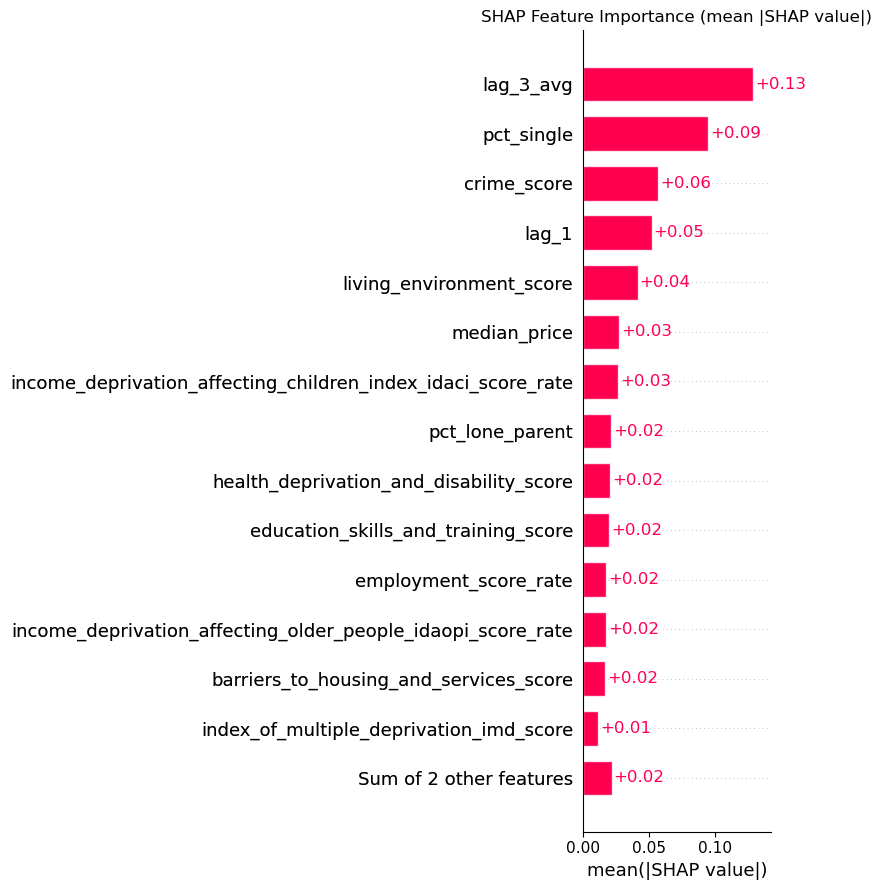

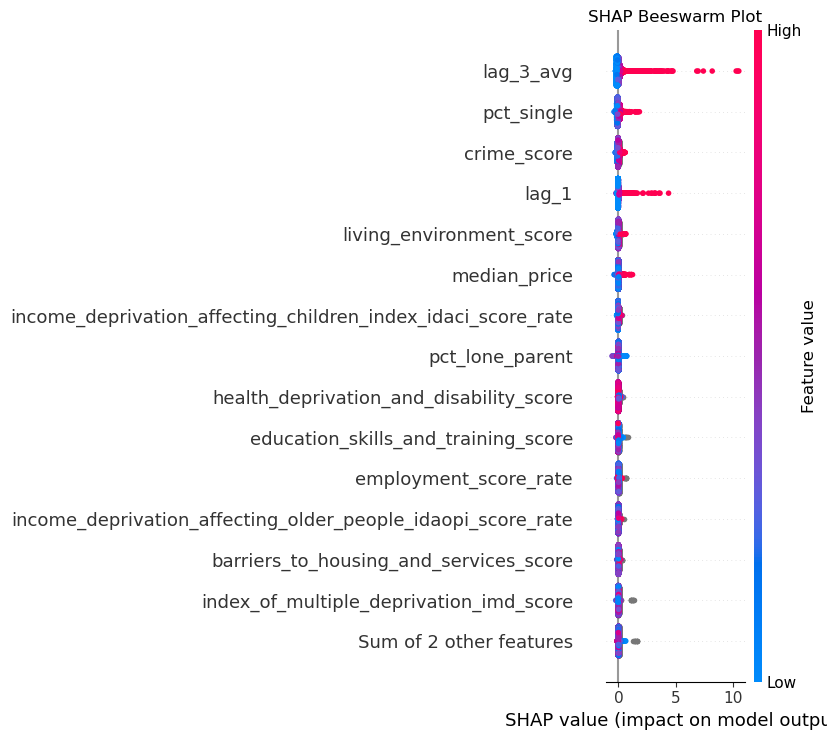

In [9]:
# ── 0) (Re)install Optuna if needed ──
# ── 1) Imports ──

# ── 2) Build your modeling DataFrame (assuming df_model exists) ──
df = df_model.copy().sort_values(['lsoa_code','month'])
df['lag_1'] = df.groupby('lsoa_code')['burglary_count'].shift(1)
df['lag_3_avg'] = (
    df.groupby('lsoa_code')['burglary_count']
      .rolling(3, min_periods=1).mean()
      .shift(1)
      .reset_index(level=0, drop=True)
)
df = df.dropna(subset=['lag_1','lag_3_avg'])
cutoff = df['month'].quantile(0.80)
train = df[df['month'] <= cutoff]
test  = df[df['month']  > cutoff]

X_cols = [
    'lag_1','lag_3_avg',
    'index_of_multiple_deprivation_imd_score',
    'income_score_rate','employment_score_rate',
    'education_skills_and_training_score',
    'health_deprivation_and_disability_score',
    'crime_score','barriers_to_housing_and_services_score',
    'living_environment_score',
    'income_deprivation_affecting_children_index_idaci_score_rate',
    'income_deprivation_affecting_older_people_idaopi_score_rate',
    'pct_single','pct_lone_parent','pct_unemployed','median_price'
]
X_train, y_train = train[X_cols], train['burglary_count']
X_test,  y_test  = test [X_cols],  test ['burglary_count']

# ── 3) Optuna hyperparameter tuning (no early_stopping_rounds) ──
def objective(trial):
    params = {
        'n_estimators':     trial.suggest_int('n_estimators',    50, 300),
        'max_depth':        trial.suggest_int('max_depth',       3,  10),
        'learning_rate':    trial.suggest_float('learning_rate',  0.01, 0.3, log=True),
        'subsample':        trial.suggest_float('subsample',      0.5,  1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree',0.5,  1.0),
        'random_state':     42,
        'n_jobs':           -1
    }
    m = XGBRegressor(**params)
    m.fit(X_train, y_train)                    # plain fit
    preds = m.predict(X_test)
    return np.sqrt(((preds - y_test) ** 2).mean())  # RMSE

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

best_params = study.best_params

# ── 4) Train final model ──
model = XGBRegressor(**best_params, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

# ── 5) SHAP explainability ──
explainer = shap.Explainer(model)
shap_vals = explainer(X_test)

plt.figure()
shap.plots.bar(shap_vals, max_display=15, show=False)
plt.title("SHAP Feature Importance (mean |SHAP value|)")
plt.tight_layout()
plt.savefig("shap_feature_importance.png", dpi=300, bbox_inches="tight")
plt.show()

plt.figure()
shap.plots.beeswarm(shap_vals, max_display=15, show=False)
plt.title("SHAP Beeswarm Plot")
plt.tight_layout()
plt.savefig("shap_beeswarm.png", dpi=300, bbox_inches="tight")
plt.show()

# Interpretation of Feature Importance Plot
- `lag_3_avg` of mean $| \text{\small{SHAP}}| \approx 0.14$
    - The previous 3 months of burglaries is the strongest predictor of the model's output. Any change present in these 3 months fluctuates the predictions the most.
- `pct_single` of $\approx 0.1$
    - The next most influential predictor is a socio-demographic variable which is the proportion of single-person households.
- `crime_score` of $\approx 0.06$
    - Static LSOA crime-risk score.
- `lag_1` of $\approx 0.05$
    - Burglary count of 1 month lag's impact is below the half of 3 months lag variable's impact.
- `living_environment_score` of $\approx 0.04$
- mid-tier predictors of $\approx 0.02 to 0.03$
    - `median_price` and various sub-domains (health, education, barriers to housing, income deprivation for elderies)
- lower-impact features of $\approx 0.01$
    - Employment rate, income rate.


# Interpretation of Beeswarm Plot
- X-axis (SHAP value):
    - Positive value pushes the model to predict more burglaries.
    - Negative value pushes the model to predict less burglaries.
- Each scatter (dot) represents one LSOA-month instance.
- Red dots (high feature value) are observed in the right side of the x-axis for `lag_3_avg`. This means high counts of recent burglary results in higher forecasted risks.
- Blue dots are clustered on the left for majority of predictors. 
- Single-person household (`pct_sngle`) also encourages higher predictions but not as strong as `lag_1`.

# 4. (Optional) EDAs

In [10]:
print(df_model.head())
print(df_model.describe(include='all').T)

   lsoa_code      month  burglary_count  year  \
0  E01000001 2022-07-01               1  2022   
1  E01000001 2023-01-01               1  2023   
2  E01000001 2024-10-01               1  2024   
3  E01000001 2024-11-01               1  2024   
4  E01000002 2021-06-01               1  2021   

   index_of_multiple_deprivation_imd_score  income_score_rate  \
0                                    6.208              0.007   
1                                    6.208              0.007   
2                                    6.208              0.007   
3                                    6.208              0.007   
4                                    5.143              0.034   

   employment_score_rate  education_skills_and_training_score  \
0                  0.010                                0.024   
1                  0.010                                0.024   
2                  0.010                                0.024   
3                  0.010                              

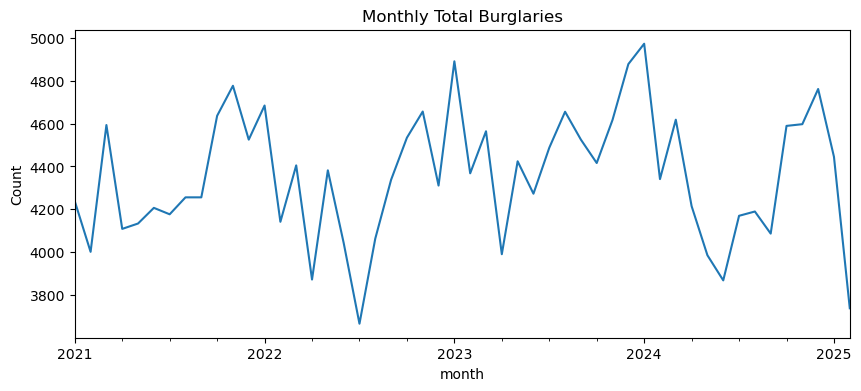

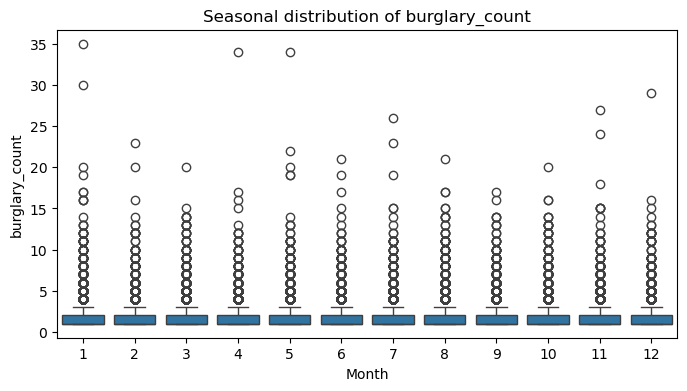

In [11]:
# Total burglaries over time
agg = df_model.groupby('month')['burglary_count'].sum()
plt.figure(figsize=(10,4))
agg.plot()
plt.title("Monthly Total Burglaries")
plt.ylabel("Count")
plt.show()

# Seasonality boxplot
plt.figure(figsize=(8,4))
sns.boxplot(x=df_model['month'].dt.month, y=df_model['burglary_count'])
plt.xlabel("Month")
plt.title("Seasonal distribution of burglary_count")
plt.show()